In [1]:
import requests
import tarfile
from io import BytesIO

# Fetching the Dataset Using its Public API 
# Dataset:  Pascal VOC 2007 dataset

In [3]:
url = "http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar"


response = requests.get(url)
tar = tarfile.open(fileobj=BytesIO(response.content), mode="r:")
tar.extractall(path="VOCtrainval_06-Nov-2007")
tar.close()

In [17]:
import os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import defaultdict
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader

# Visaulizing the data

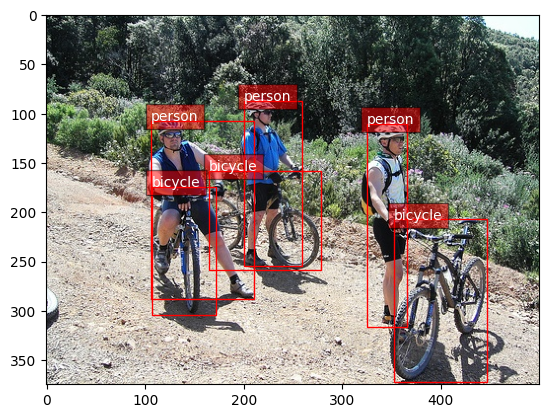

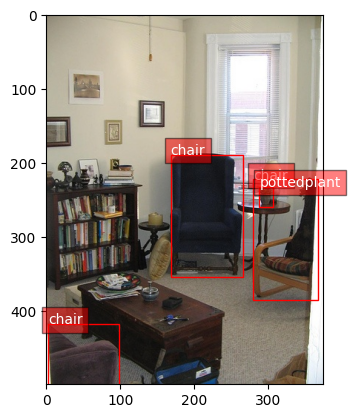

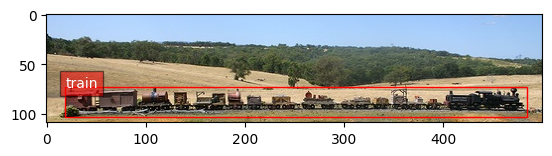

In [5]:
data_dir = "VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"
image_dir = os.path.join(data_dir, "JPEGImages")
annotation_dir = os.path.join(data_dir, "Annotations")

def plot_image_with_boxes(image_path, annotation_path):
    #opening the image
    image = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    #parsing XML annotation
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    #extracting bounding boxes and labels
    for obj in root.findall("object"):
        label = obj.find("name").text
        xmlbox = obj.find("bndbox")
        xmin = int(xmlbox.find("xmin").text)
        ymin = int(xmlbox.find("ymin").text)
        xmax = int(xmlbox.find("xmax").text)
        ymax = int(xmlbox.find("ymax").text)
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, label, color="white", bbox=dict(facecolor='red', alpha=0.5))

    plt.show()

#displaying sample of data
sample_images = os.listdir(image_dir)[:3]
for image_file in sample_images:
    image_path = os.path.join(image_dir, image_file)
    annotation_path = os.path.join(annotation_dir, image_file.replace(".jpg", ".xml"))
    plot_image_with_boxes(image_path, annotation_path)

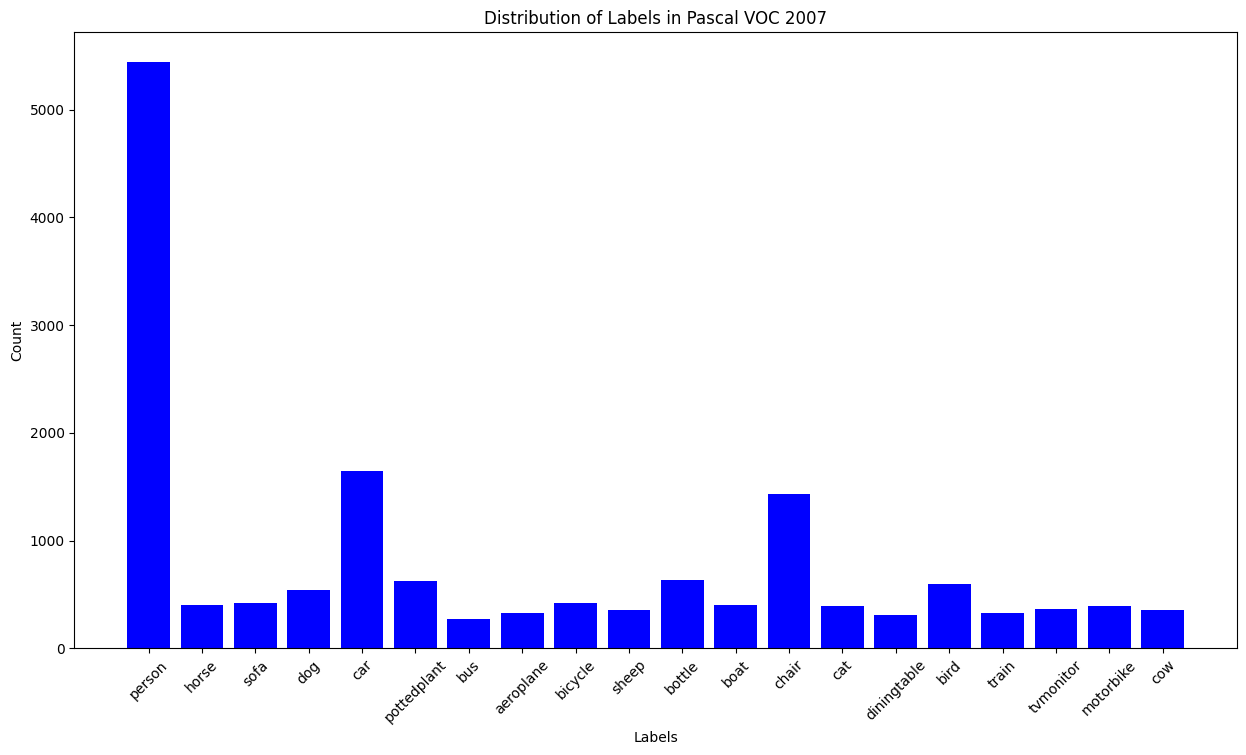

In [7]:
#plotting label distributions
def get_label_distribution(annotation_dir):
    label_count = defaultdict(int)

    annotations = os.listdir(annotation_dir)
    for annotation_file in annotations:
        tree = ET.parse(os.path.join(annotation_dir, annotation_file))
        root = tree.getroot()

        for obj in root.findall("object"):
            label = obj.find("name").text
            label_count[label] += 1

    return label_count


label_distribution = get_label_distribution(annotation_dir)


#Plotting the distribution
labels = list(label_distribution.keys())
counts = list(label_distribution.values())


plt.figure(figsize=(15, 8))
plt.bar(labels, counts, color='blue')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks(rotation=45)

plt.show()

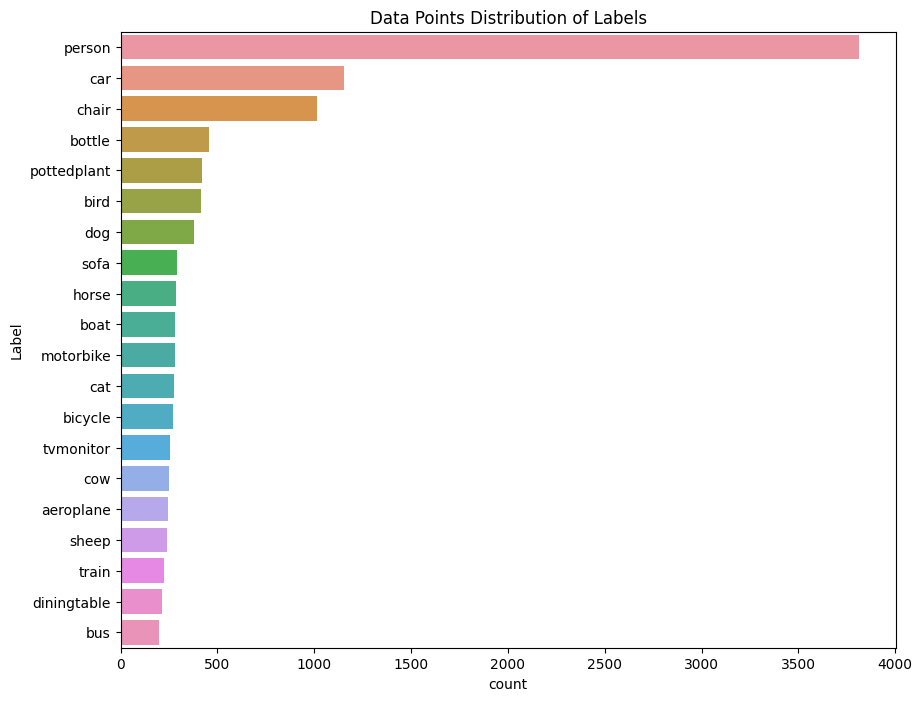

In [15]:
#creating a df where each label appears as many times as its count
expanded_labels = []
for label, count in label_distribution.items():
    expanded_labels.extend([label] * count)

#convert to df
df_expanded = pd.DataFrame(expanded_labels, columns=['Label'])

#display only 70% of the data points
selected_indices = np.random.choice(df_expanded.index, size=int(len(df_expanded) * 0.7), replace=False)
df_selected = df_expanded.loc[selected_indices]


plt.figure(figsize=(10, 8))
sns.countplot(y='Label', data=df_selected, order = df_selected['Label'].value_counts().index)
plt.title('Data Points Distribution of Labels')
plt.show()

## There are 20 unique classes in the dataset
## Distributed as:
### 1)Person: person
### 2)Animal: bird, cat, cow, dog, horse, sheep
### 3)Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
### 4)Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

## Data split

In [16]:
trainval_txt_path = os.path.join(data_dir, "ImageSets/Main/trainval.txt")
with open(trainval_txt_path, "r") as file:
    trainval_files = file.readlines()



# Calculating indices for the splits
train_idx = int(0.75 * len(trainval_files))
val_idx = train_idx + int(0.15 * len(trainval_files))

# Splitting the data
train_files = trainval_files[:train_idx]
val_files = trainval_files[train_idx:val_idx]
test_files = trainval_files[val_idx:]

print(f"Number of training samples: {len(train_files)}")
print(f"Number of validation samples: {len(val_files)}")
print(f"Number of test samples: {len(test_files)}")

Number of training samples: 3758
Number of validation samples: 751
Number of test samples: 502


## Data loader and pre-processing

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader

class VOCDataset(Dataset):
    def __init__(self, file_list, image_dir, annotation_dir, transform=None):
        self.file_list = file_list
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        image_file = self.file_list[idx].strip() + ".jpg"
        annotation_file = self.file_list[idx].strip() + ".xml"

        image_path = os.path.join(self.image_dir, image_file)
        annotation_path = os.path.join(self.annotation_dir, annotation_file)

        #load image
        image = Image.open(image_path).convert('RGB')

        # Load and parse XML annotation
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []
        for obj in root.findall("object"):
            label = obj.find("name").text
            #converting the labels into integer format
            label_id = int(label) if label.isdigit() else 0
            labels.append(label_id)

            xmlbox = obj.find("bndbox")
            xmin = float(xmlbox.find("xmin").text)
            ymin = float(xmlbox.find("ymin").text)
            xmax = float(xmlbox.find("xmax").text)
            ymax = float(xmlbox.find("ymax").text)
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        if self.transform:
            image, target = self.transform(image, target)

        return image, target

#preprocess
transform = transforms.Compose([
    transforms.Resize((416, 416)),  #YOLO model image/dimension size input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [19]:
train_dataset = VOCDataset(train_files, image_dir, annotation_dir, transform=transform)
val_dataset = VOCDataset(val_files, image_dir, annotation_dir, transform=transform)
test_dataset = VOCDataset(test_files, image_dir, annotation_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=None)  # You might need a custom collate_fn
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=None)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=None)

# setting up yolo v5

In [20]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 16013, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 16013 (delta 23), reused 24 (delta 13), pack-reused 15967
Receiving objects: 100% (16013/16013), 14.60 MiB | 10.94 MiB/s, done.
Resolving deltas: 100% (10989/10989), done.
/content/yolov5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.5/644.5 kB 41.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.1 MB/s eta 0:00:00


## we need to configure some setting and make yaml file

In [22]:
#Paths
data_dir = "/content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007"
images_dir = os.path.join(data_dir, "JPEGImages")
labels_dir = "/content/VOCtrainval_06-Nov-2007/labels"  # We'll store YOLO format labels here

#Creating directories
os.makedirs(labels_dir, exist_ok=True)

# Save train, val, and test file paths
with open(os.path.join(data_dir, "train.txt"), "w") as f:
    for path in train_files:
        f.write(os.path.join(images_dir, path.strip() + ".jpg") + "\n")

with open(os.path.join(data_dir, "val.txt"), "w") as f:
    for path in val_files:
        f.write(os.path.join(images_dir, path.strip() + ".jpg") + "\n")

with open(os.path.join(data_dir, "test.txt"), "w") as f:
    for path in test_files:
        f.write(os.path.join(images_dir, path.strip() + ".jpg") + "\n")

In [36]:
#Create the voc.yaml file
import yaml


voc_yaml_content = """
names: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
nc: 20
train: /content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/train.txt
val: /content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/val.txt
test: /content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/test.txt
"""

#with open("voc.yaml", "w") as f:
#    f.write(voc_yaml_content)

with open('data.yaml', 'w') as outfile:
    yaml.dump(voc_yaml_content, outfile, default_flow_style=True)


In [33]:
voc_yaml_content

"\nnames: ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']\nnc: 20\ntrain: /content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/train.txt\nval: /content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/val.txt\n"

In [34]:
type(voc_yaml_content)

str

In [26]:
import os
import xml.etree.ElementTree as ET

def convert_annotation(image_id, labels_dir):
    in_file = open(f'/content/VOCtrainval_06-Nov-2007/VOCdevkit/VOC2007/Annotations/{image_id}.xml')
    out_file = open(f'{labels_dir}/{image_id}.txt', 'w')
    tree = ET.parse(in_file)
    root = tree.getroot()

    # Mapping class names to IDs
    classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        out_file.write(f"{cls_id} {(b[0]+b[2])/2/w} {(b[1]+b[3])/2/h} {(b[2]-b[0])/w} {(b[3]-b[1])/h}\n")

labels_dir = "/content/VOCtrainval_06-Nov-2007/labels"
os.makedirs(labels_dir, exist_ok=True)

for image_id in train_files + val_files:
    convert_annotation(image_id.strip(), labels_dir)


# Training

In [49]:
!python train.py --img 416 --batch 16 --epochs 20 --data voc.yaml --cfg models/yolov5s.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=voc.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-228-g4d687c8 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=

# Results

In [14]:
from IPython.display import Image
import numpy as np

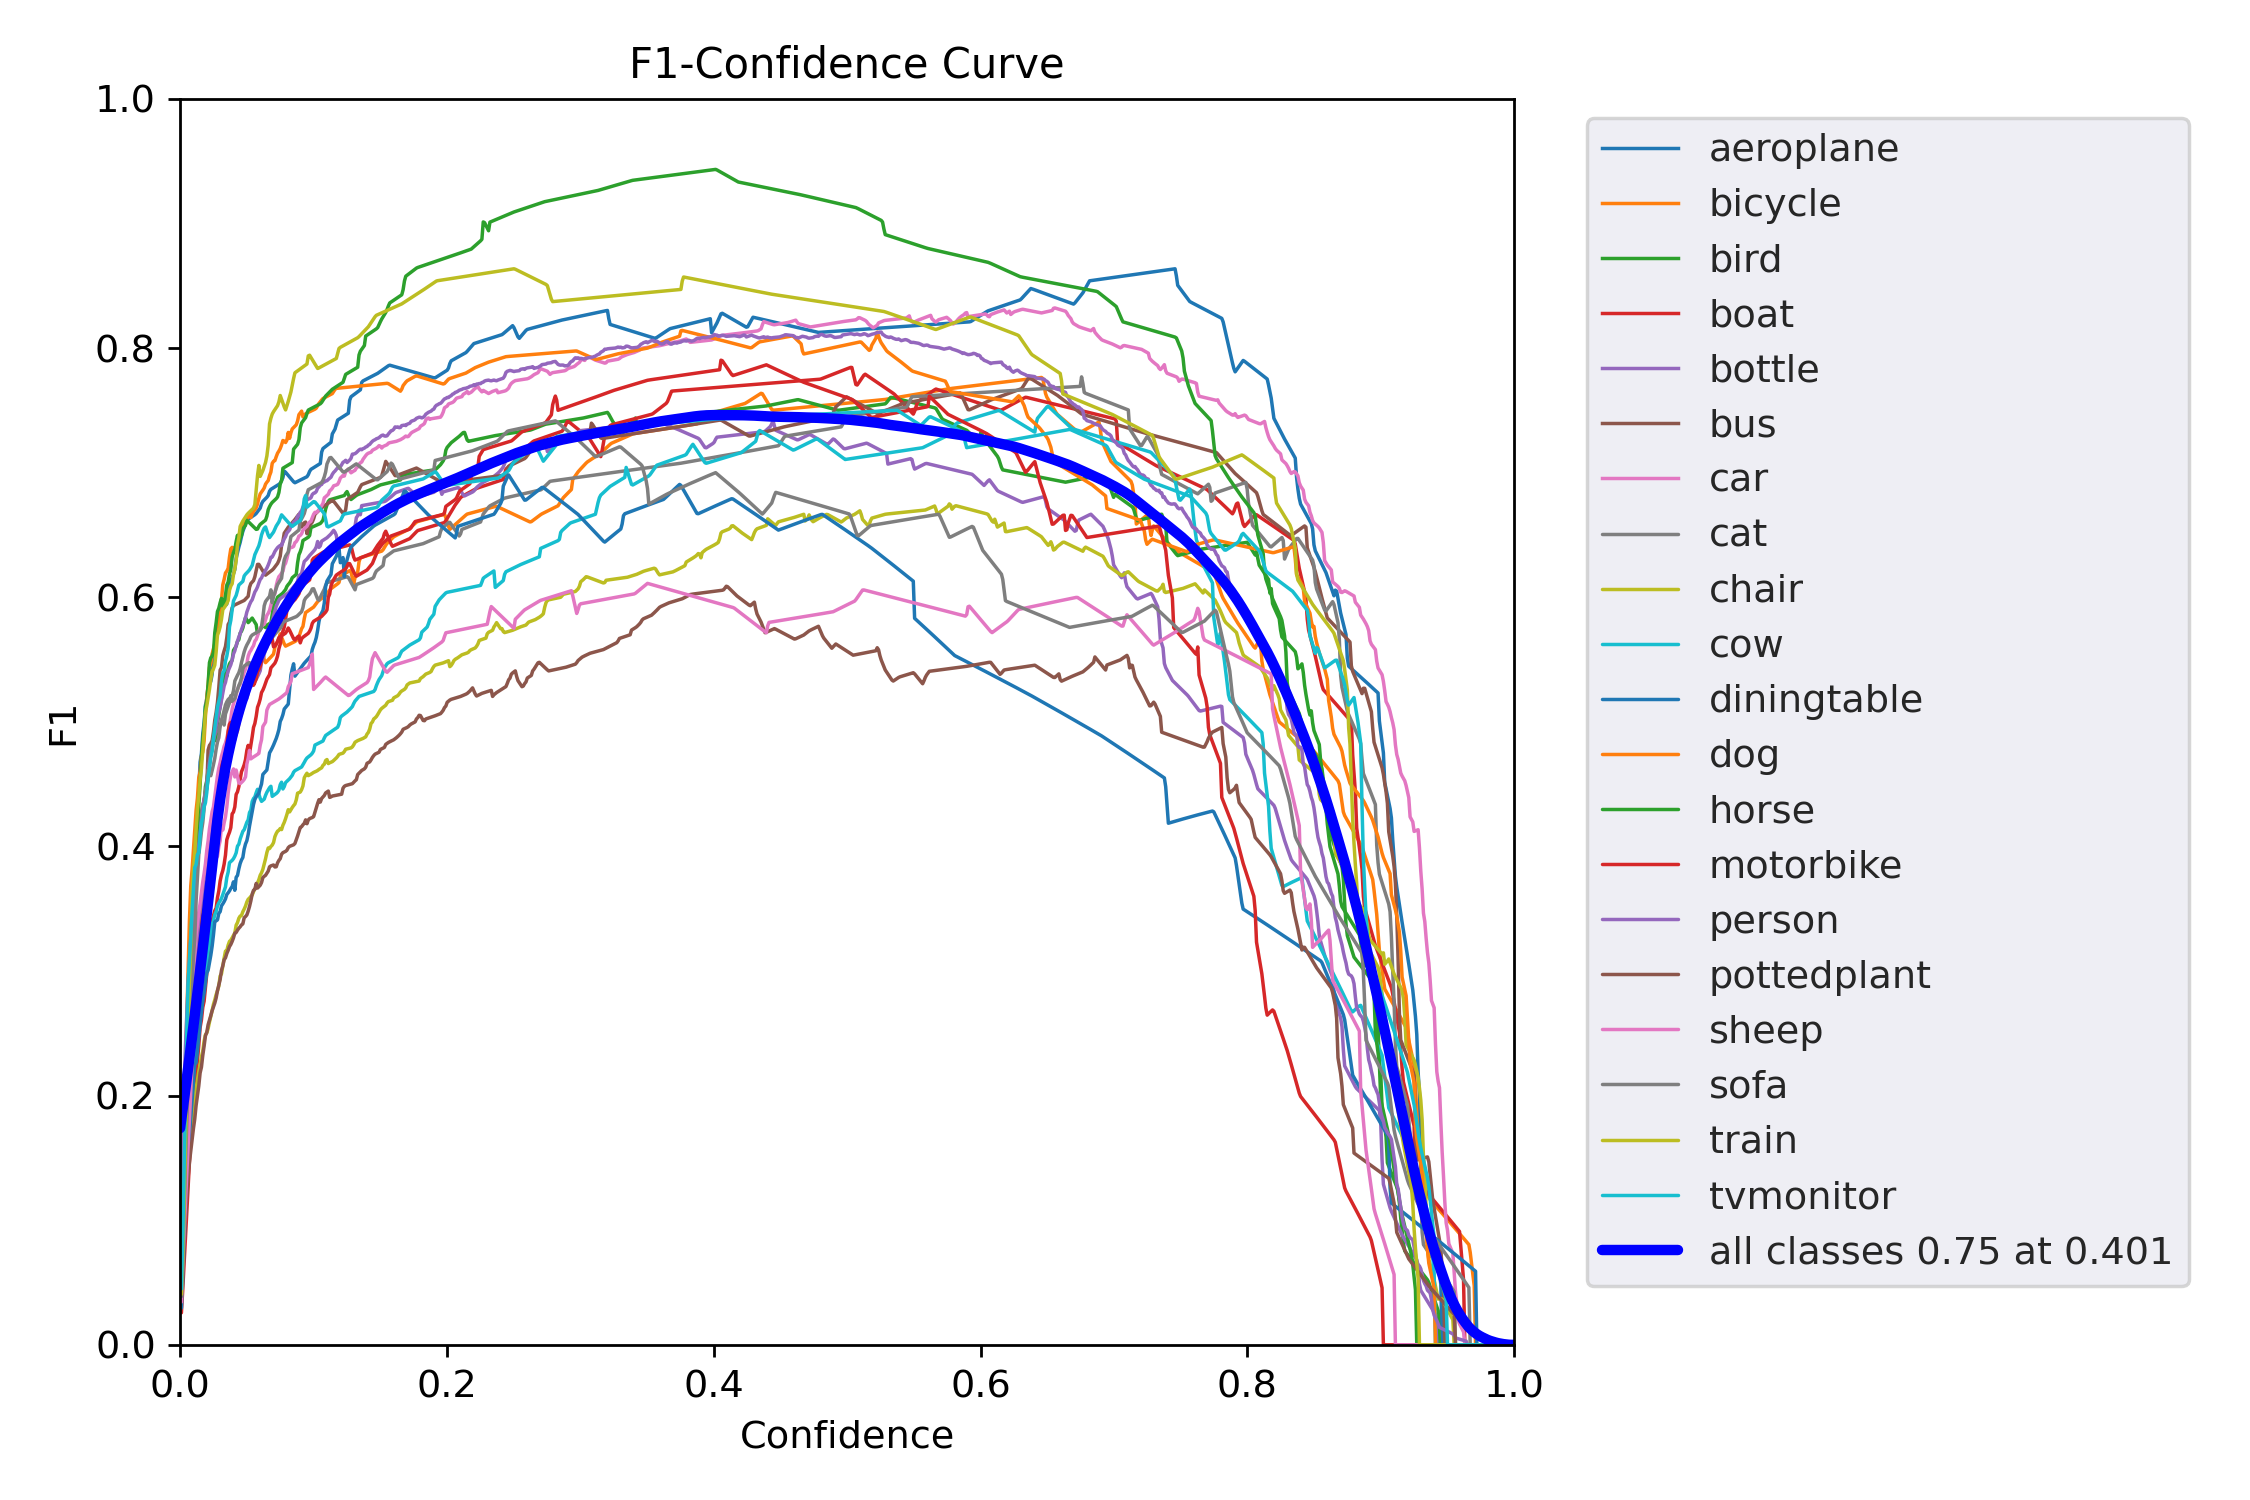

In [10]:
#f1 graph
Image(filename= 'C:\\Users\\results\\F1_curve.png')

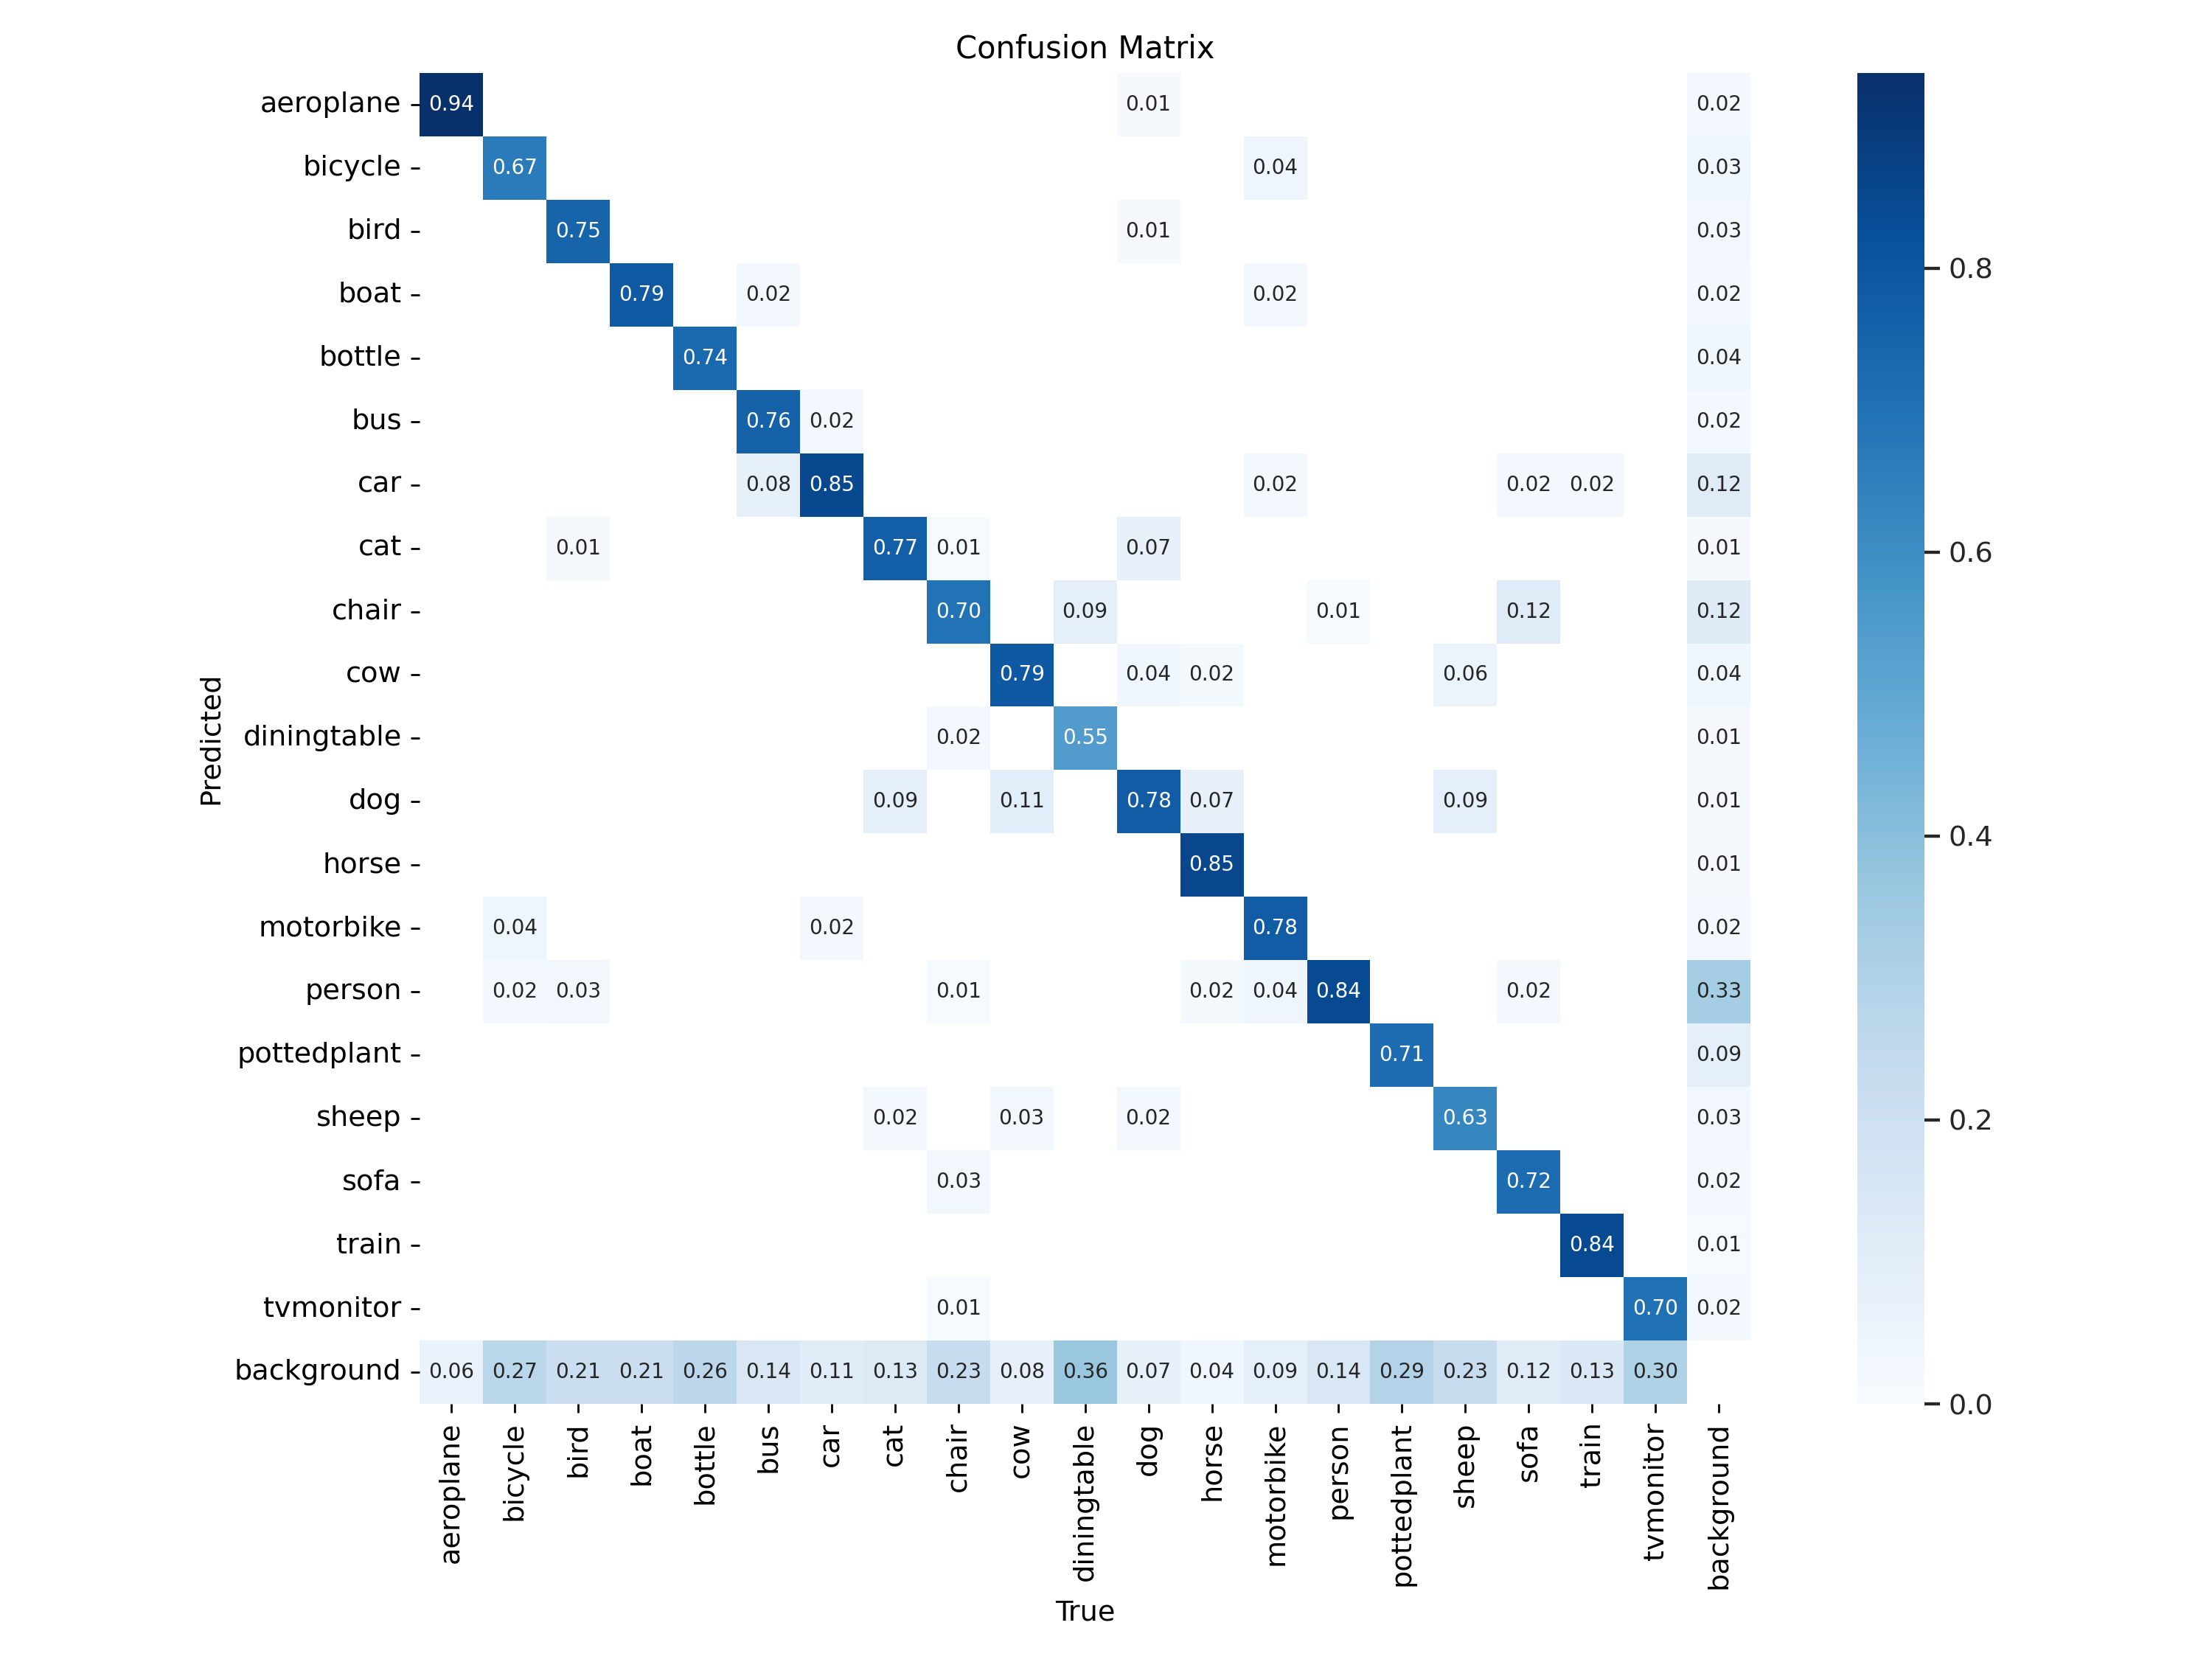

In [11]:
#confusion matrix
Image(filename= 'C:\\Users\\results\\confusion_matrix.png')

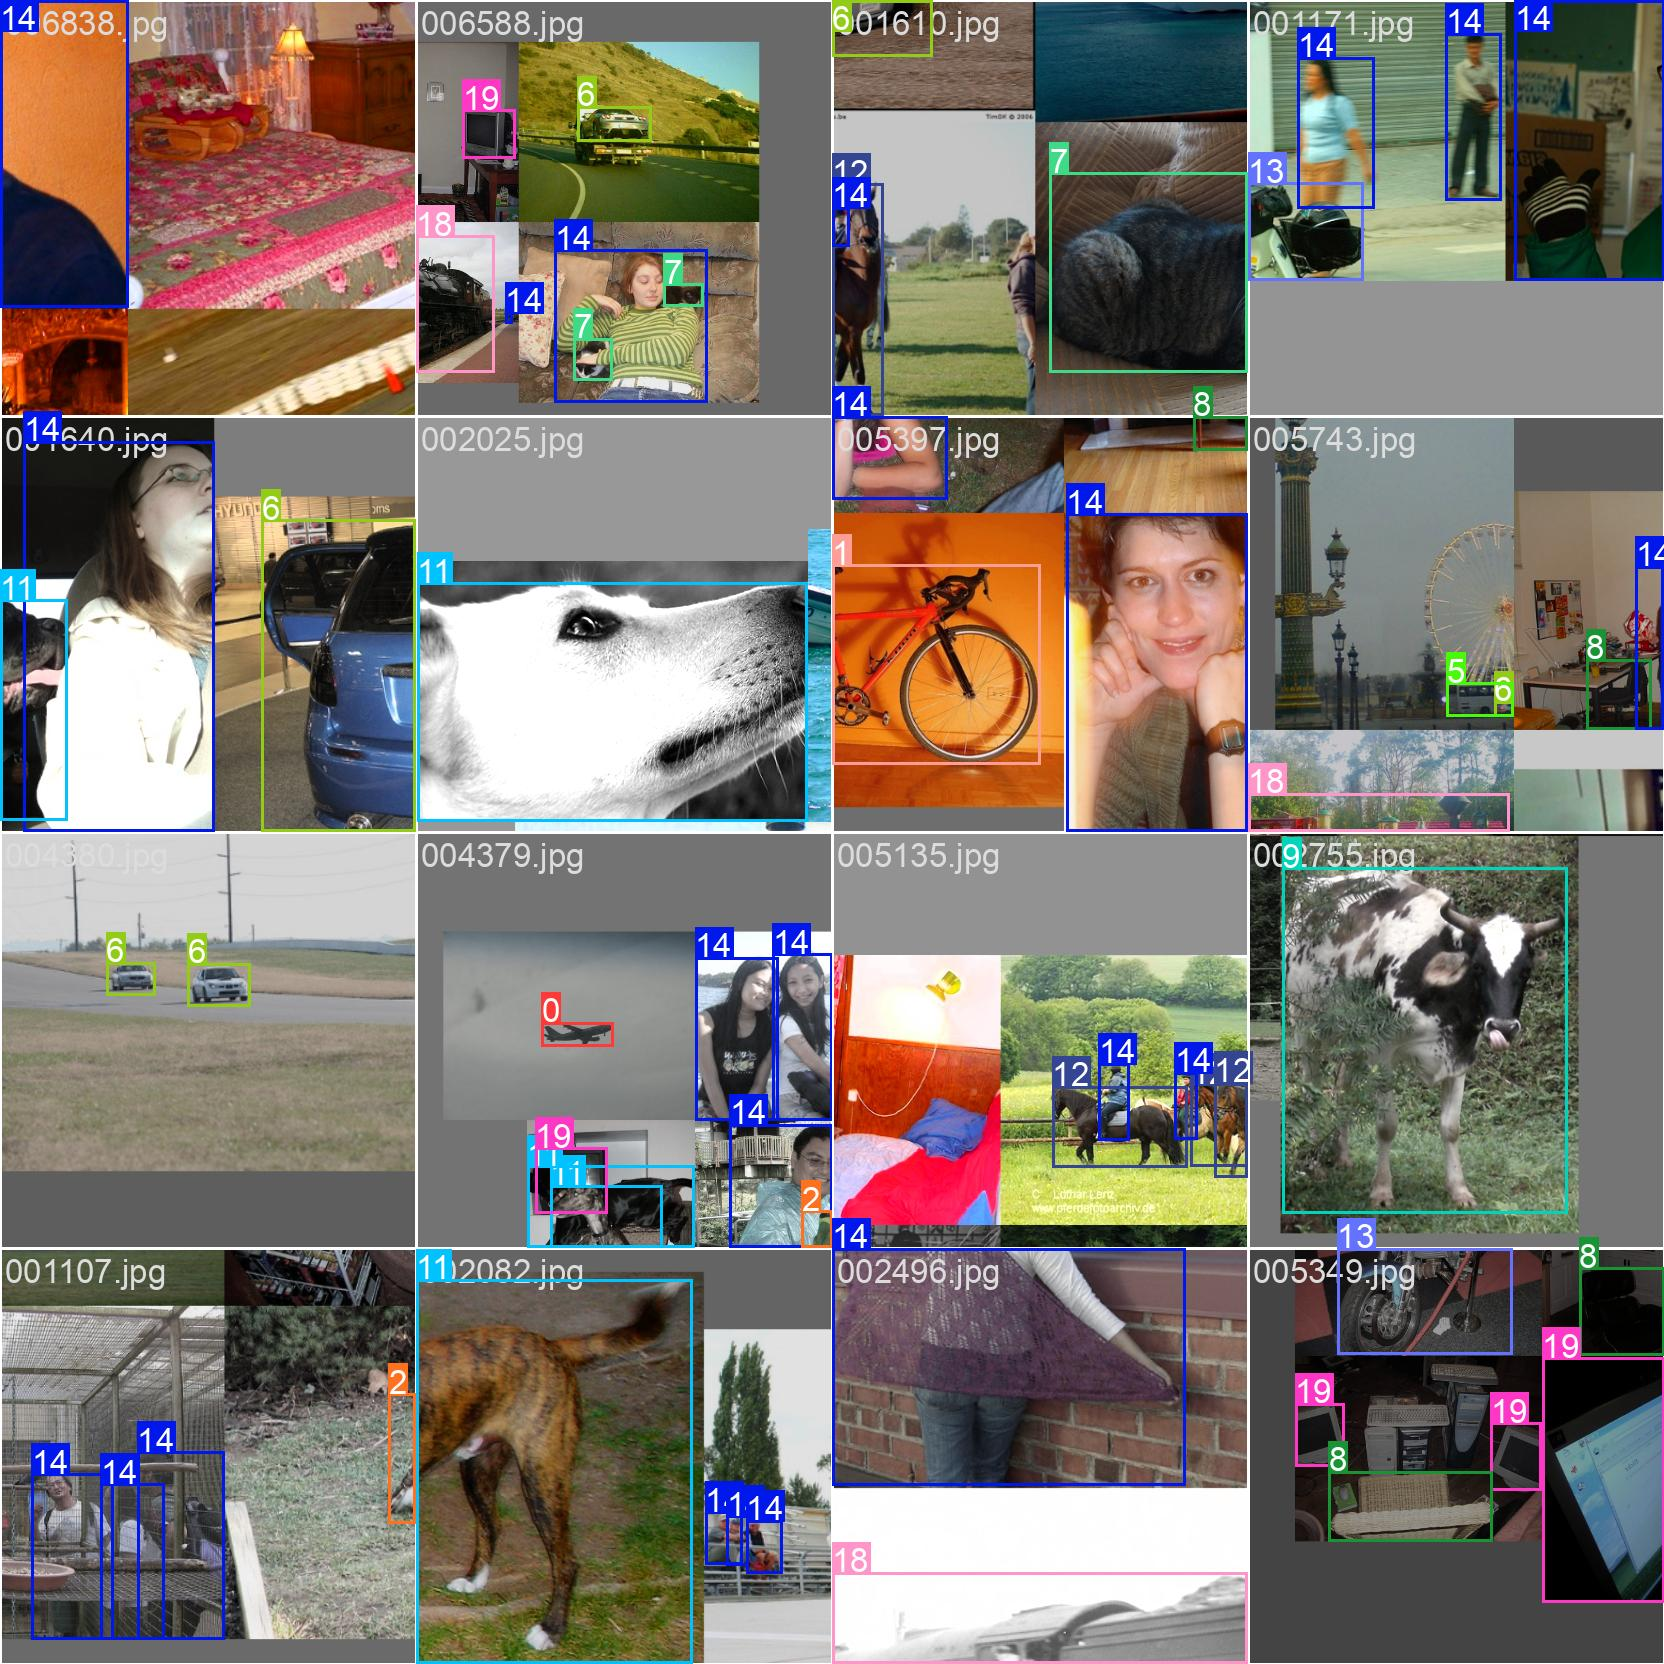

In [20]:
#train batch
Image(filename= 'C:\\Users\\results\\train_batch2.jpg')

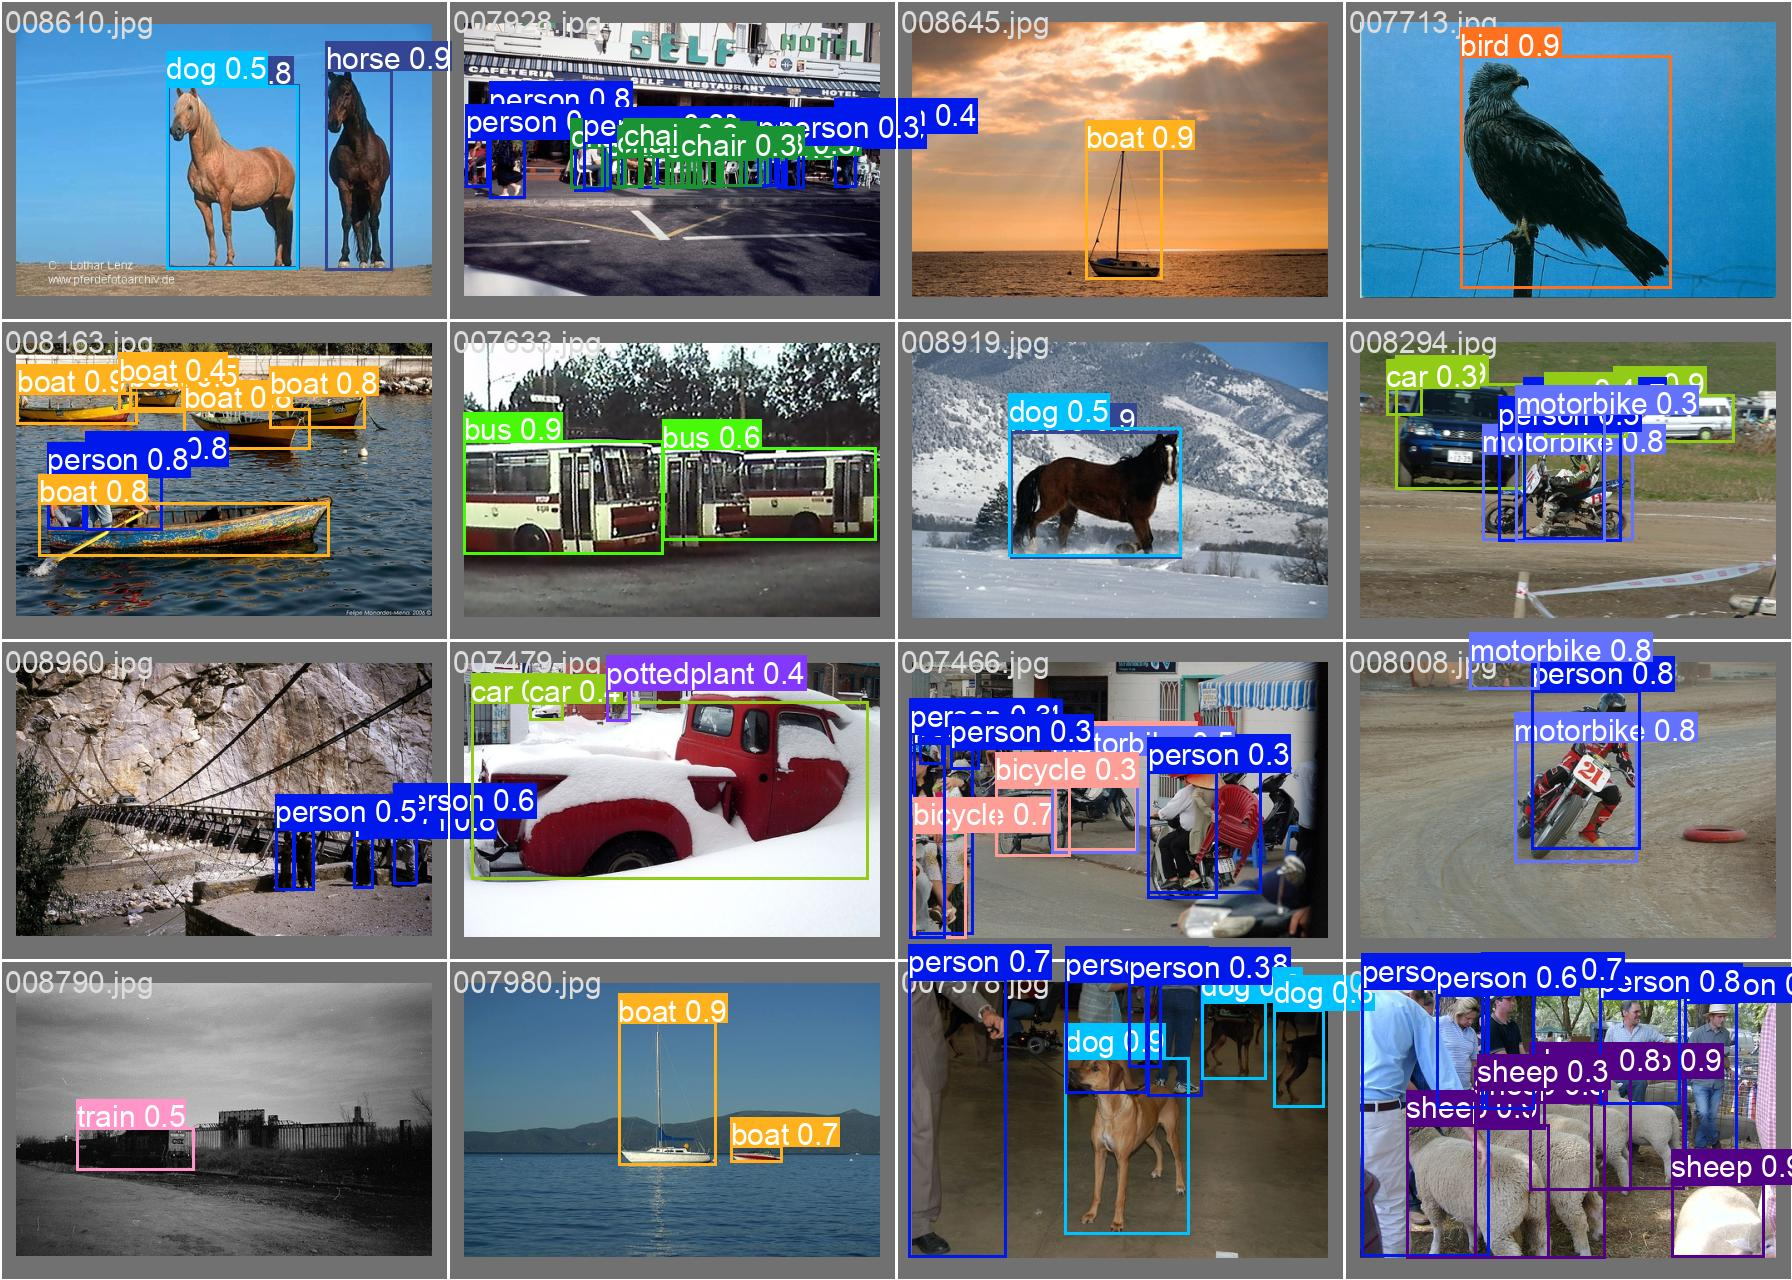

In [21]:
#train batch
Image(filename= 'C:\\Users\\results\\val_batch1_pred.jpg')